In [ ]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 4. 인플루언서 YouTuber 되기 실습


# **1. 모듈 설치 및 호출**

In [ ]:
!pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.1 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=63330fb711565803f1331dc3efb9ffce73b64e269eedc8bba06cbd8bab807d3a
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [ ]:
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint

import chardet
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm


pd.set_option('display.max_columns', None)

# **2. 데이터 로드 및 탐색적 데이터 분석**

In [ ]:
# KRvideos.csv 데이터 파일을 Colab에 업로드
# Data link: https://www.kaggle.com/datasnaek/youtube-new
# 여러 나라 data file중 한국 데이터 (KRvideos.csv) 사용

#from google.colab import files, drive
#file_uploaded = files.upload()

In [ ]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
#! ls /content

 KRvideos.csv							    sample_data
'KRvideos(본래 파일이 변환이 안 되시면 이 파일을 사용하세요).csv'


In [ ]:
filename = 'KRvideos(본래 파일이 변환이 안 되시면 이 파일을 사용하세요).csv'
with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: UTF-8-SIG


In [ ]:
raw_data = pd.read_csv(filename, engine='python',   encoding="UTF-8-SIG")
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [ ]:
# KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36897 entries, 0 to 36896
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                36741 non-null  object
 1   trending_date           34730 non-null  object
 2   title                   34592 non-null  object
 3   channel_title           34575 non-null  object
 4   category_id             34572 non-null  object
 5   publish_time            34568 non-null  object
 6   tags                    34568 non-null  object
 7   views                   34568 non-null  object
 8   likes                   34568 non-null  object
 9   dislikes                34568 non-null  object
 10  comment_count           34568 non-null  object
 11  thumbnail_link          34568 non-null  object
 12  comments_disabled       34567 non-null  object
 13  ratings_disabled        34567 non-null  object
 14  video_error_or_removed  34567 non-null  object
 15  de

In [ ]:
raw_data['description'].isnull().sum()

5493

In [ ]:
raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum()

511

In [ ]:
raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum()

1400

In [ ]:
raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum()

41

In [ ]:
for i in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts())
    print('\n')

video_id
True     20563
False    16334
Name: video_id, dtype: int64


trending_date
True     36623
False      274
Name: trending_date, dtype: int64


title
True     20529
False    16368
Name: title, dtype: int64


channel_title
True     32849
False     4048
Name: channel_title, dtype: int64


category_id
True     36875
False       22
Name: category_id, dtype: int64


publish_time
True     21033
False    15864
Name: publish_time, dtype: int64


tags
True     26104
False    10793
Name: tags, dtype: int64


views
False    30692
True      6205
Name: views, dtype: int64


likes
True     27421
False     9476
Name: likes, dtype: int64


dislikes
True     34820
False     2077
Name: dislikes, dtype: int64


comment_count
True     32206
False     4691
Name: comment_count, dtype: int64


thumbnail_link
True     20806
False    16091
Name: thumbnail_link, dtype: int64


comments_disabled
True     36894
False        3
Name: comments_disabled, dtype: int64


ratings_disabled
True     36894
False     

In [ ]:
df = raw_data[raw_data['comments_disabled'] != 1]
df = df[df['ratings_disabled'] != 1]
df = df[df['video_error_or_removed'] != 1]
df = df[df['tags'] != '[none]']
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [ ]:
print('Before dropna:', len(df))
df = df.dropna()
print('After  dropna:', len(df))
df = df.reset_index(drop=True)

Before dropna: 28408
After  dropna: 24768


#**3. 피쳐 엔지니어링**

In [ ]:
r_avg = []
g_avg = []
b_avg = []

for i in tqdm.tqdm(range(len(df))):
    url = df['thumbnail_link'][i]
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    red, green, blue = request_get_img.split()

    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

100%|██████████| 24768/24768 [10:44<00:00, 38.42it/s]


In [ ]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


In [ ]:
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('Before removing non-thumbnail images:', len(df))
df_rgb = df[df['r_avg'] != 193]
print('After  removing non-thumbnail images:', len(df_rgb))
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False)

len_check_table: 10081
Before removing non-thumbnail images: 24768
After  removing non-thumbnail images: 14807


In [ ]:
# df_rgb = pd.read_csv('df_color_encode.csv')
print(df['video_id'].duplicated().value_counts())
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

True     13672
False    11096
Name: video_id, dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
13046,#NAME?,18.26.05,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,RT TV,22,2018-05-25T09:20:17.000Z,"bts anpanman reaction|""bts anpanman comeback s...",221175,8496,84,331,https://i.ytimg.com/vi/-qFrHv2XbBY/default.jpg,False,False,False,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,95,93,83
1471,#NAME?,17.04.12,Ep 37.문과 1등 이과 1등 담배 피우는 뒤에서 1등을 발견하다~!!!,1등 미디어,23,2017-12-01T07:30:00.000Z,"웃찾사|""문과1등""|""이과1등""|""이그젝틀리""|""이과젝틀리""|""김성기""|""신흥재""|...",427430,6819,159,2314,https://i.ytimg.com/vi/-eogDUxczeE/default.jpg,False,False,False,오늘도 평화롭게 길을 가던 문과이과에 눈에 띈\n담배피는 뒤에서 1등!!!\n과연 ...,76,69,68
13300,#NAME?,18.30.05,총을 못 만지는 남자가 군대에 가서 보여준 기적적인 실화,미들뻔,1,2018-05-26T10:30:47.000Z,"미들뻔|""미드펀""|""미드뻔""|""미들펀""|""뻔펀""|""영화""|""영화 추천""|""영화 소개...",973039,8051,293,2232,https://i.ytimg.com/vi/-ArRPlpU9Tc/default.jpg,False,False,False,"안녕하세요, 미들뻔입니다.오늘 리뷰할 작품은 '핵소 고지(Hacksaw Ridge ...",73,69,55
9518,#NAME?,18.06.04,중국에서 유행한다는 신기한 액체얼음을 먹어보았습니다! 이건 얼음인가 액체인가?! - 허팝,허팝Heopop,24,2018-04-02T12:16:14.000Z,"허팝|""heopop""|""gjvkq""|""중국""|""얼음""|""겉에만 언 얼음""|""속은 물...",760427,9185,699,1549,https://i.ytimg.com/vi/-A62Br1WkOs/default.jpg,False,False,False,요즘 중국에선 이런 신기한 얼음을 먹는다고 해요... 중국은 벌써부터 엄청 더운건가...,125,125,114
9505,#NAME?,18.06.04,"예수님과 동행하는 삶_유기성 목사,박리부가 사모(선한목자교회), 내가매일기쁘게201...",CTS기독교TV,29,2018-04-03T03:04:22.000Z,"기독교|""CTS""|""기독교텔레비전""|""CTS기독교TV""|""CTSTV""|""기독교방송""...",56884,500,53,30,https://i.ytimg.com/vi/-swmzN_BQWQ/default.jpg,False,False,False,은혜로운 간증으로 살아계신 하나님을 전하는 크리스천 토크 프로그램 \n[내가 매일 ...,107,95,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7584,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7466,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7396,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11205,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [ ]:
df_rgb[df_rgb['video_id']=='#NAME?']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
33,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
116,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
155,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
156,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
204,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14577,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14638,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14717,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14752,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [ ]:
print('Before removing duplicated video_id:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('After  removing duplicated video_id:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

Before removing duplicated video_id: 14807
After  removing duplicated video_id: 6491


In [ ]:
df_rgb2.head(5)

In [ ]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0])
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]')
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6486   2018-06-11
6487   2018-06-13
6488   2018-06-13
6489   2018-06-13
6490   2018-06-13
Name: publish_date, Length: 6491, dtype: datetime64[ns]

In [ ]:
df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6486   2018-06-14
6487   2018-06-14
6488   2018-06-14
6489   2018-06-14
6490   2018-06-14
Name: trending_date, Length: 6491, dtype: datetime64[ns]

In [ ]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6486    4
6487    2
6488    2
6489    2
6490    2
Name: elapsed_day, Length: 6491, dtype: int64

In [ ]:
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)


In [ ]:
df_rgb2 = df_rgb2.astype({'likes':int, 'dislikes':int})
df_rgb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6491 entries, 0 to 6490
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                6491 non-null   object        
 1   trending_date           6491 non-null   datetime64[ns]
 2   title                   6491 non-null   object        
 3   channel_title           6491 non-null   object        
 4   category_id             6491 non-null   object        
 5   publish_time            6491 non-null   object        
 6   tags                    6491 non-null   object        
 7   views                   6491 non-null   object        
 8   likes                   6491 non-null   int64         
 9   dislikes                6491 non-null   int64         
 10  comment_count           6491 non-null   object        
 11  thumbnail_link          6491 non-null   object        
 12  comments_disabled       6491 non-null   object  

In [ ]:
df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5)


In [ ]:
df_rgb2 = df_rgb2.astype({'total_number_of_sign':int, 'elapsed_day':int})
df_rgb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6491 entries, 0 to 6490
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                6491 non-null   object        
 1   trending_date           6491 non-null   datetime64[ns]
 2   title                   6491 non-null   object        
 3   channel_title           6491 non-null   object        
 4   category_id             6491 non-null   object        
 5   publish_time            6491 non-null   object        
 6   tags                    6491 non-null   object        
 7   views                   6491 non-null   object        
 8   likes                   6491 non-null   int64         
 9   dislikes                6491 non-null   int64         
 10  comment_count           6491 non-null   object        
 11  thumbnail_link          6491 non-null   object        
 12  comments_disabled       6491 non-null   object  

In [ ]:

df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

In [ ]:
df_rgb2 = df_rgb2.astype({'comment_count':int})
df_rgb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6491 entries, 0 to 6490
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                6491 non-null   object        
 1   trending_date           6491 non-null   datetime64[ns]
 2   title                   6491 non-null   object        
 3   channel_title           6491 non-null   object        
 4   category_id             6491 non-null   object        
 5   publish_time            6491 non-null   object        
 6   tags                    6491 non-null   object        
 7   views                   6491 non-null   object        
 8   likes                   6491 non-null   int64         
 9   dislikes                6491 non-null   int64         
 10  comment_count           6491 non-null   int64         
 11  thumbnail_link          6491 non-null   object        
 12  comments_disabled       6491 non-null   object  

In [ ]:


df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['total_sign_comment_ratio'] = \
    df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [ ]:
df_rgb2['channel_title'].value_counts()

TV Derana       103
JTBC News        90
황장수의 뉴스브리핑o      85
tbs 시민의 방송       83
o 황장수의 뉴스브리핑     76
               ... 
렛츠고 TV            1
제이                1
Jass Records      1
TKT GMM           1
오싹튜브              1
Name: channel_title, Length: 1455, dtype: int64

In [ ]:
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print(mean_encode_channel)

df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

channel_title
!t Live             1.511620e+14
#NAME?              5.299687e+53
& 홍대 쏭카페창현 거리노래방    6.569408e+10
(MUTUBE)와꾸대장봉준      3.721085e+14
* eundaromi         2.825210e+10
                        ...     
흔한남매                3.133000e+15
히스토리                2.301280e+05
히죽HIZUK             7.773700e+04
히히튜브                2.938900e+04
힙합버스                7.641223e+09
Name: views, Length: 1455, dtype: float64


0        7.806547e+09
1        4.214090e+05
2        3.183575e+39
3       2.724714e+171
4        7.016633e+49
            ...      
6486     3.392785e+18
6487     3.081710e+43
6488     4.937098e+18
6489     2.340400e+04
6490              inf
Name: channel_title_mean_enc, Length: 6491, dtype: float64

In [ ]:
df_rgb2['category_id'].value_counts()

24    1843
25    1217
22     844
23     501
10     476
20     443
1      340
15     193
17     174
26     171
27      88
43      69
29      67
2       25
28      22
19      18
Name: category_id, dtype: int64

In [ ]:
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1               inf
10              inf
15              inf
17              inf
19     2.333178e+98
2     1.179760e+132
20              inf
22              inf
23              inf
24              inf
25              inf
26              inf
27              inf
28    2.061693e+129
29              inf
43              inf
Name: views, dtype: float64


0       inf
1       inf
2       inf
3       inf
4       inf
       ... 
6486    inf
6487    inf
6488    inf
6489    inf
6490    inf
Name: category_id_mean_enc, Length: 6491, dtype: float64

In [ ]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

                          likes  dislikes  comment_count  r_avg  g_avg  b_avg  \
likes                       1.0       NaN            NaN    NaN    NaN    NaN   
dislikes                    NaN       1.0            NaN    NaN    NaN    NaN   
comment_count               NaN       NaN       1.000000    NaN    NaN    NaN   
r_avg                       NaN       NaN            NaN    1.0    NaN    NaN   
g_avg                       NaN       NaN            NaN    NaN    1.0    NaN   
b_avg                       NaN       NaN            NaN    NaN    NaN    1.0   
elapsed_day                 NaN       NaN            NaN    NaN    NaN    NaN   
number_of_tag               NaN       NaN            NaN    NaN    NaN    NaN   
positive_ratio              NaN       NaN            NaN    NaN    NaN    NaN   
sign_per_day                NaN       NaN            NaN    NaN    NaN    NaN   
positive_ratio_per_day      NaN       NaN            NaN    NaN    NaN    NaN   
comment_per_day             

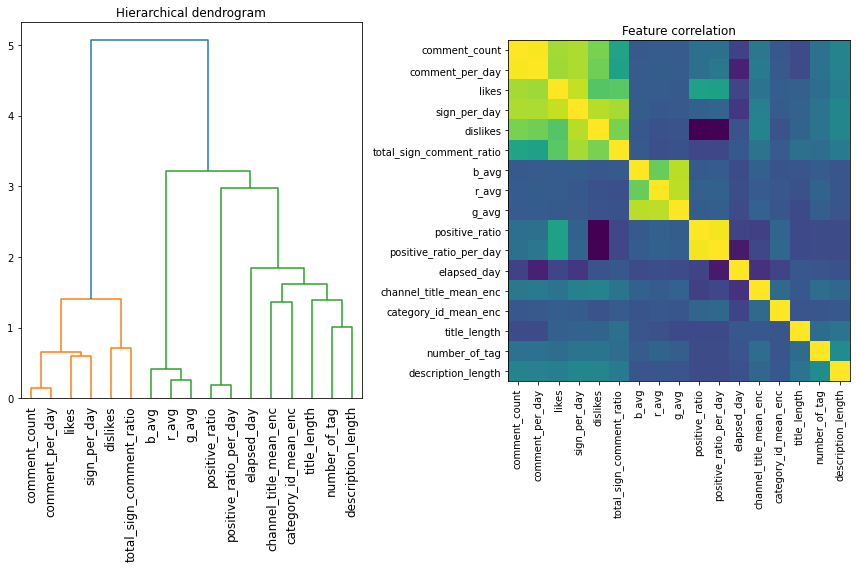

In [ ]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features]
cor_table = x_input.corr()

print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

                        likes  dislikes  comment_count  elapsed_day  \
likes                     1.0       NaN            NaN          NaN   
dislikes                  NaN       1.0            NaN          NaN   
comment_count             NaN       NaN            1.0          NaN   
elapsed_day               NaN       NaN            NaN          1.0   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

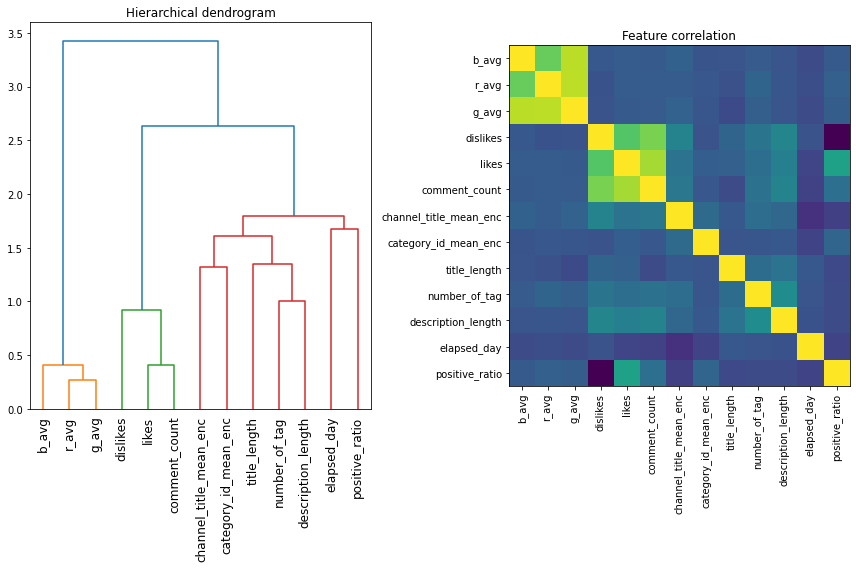

In [ ]:
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [ ]:
y_output = df_rgb2['views']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

#**4. 데이터 스케일링**

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

ValueError: ignored

#**5. 모델 생성 및 최적화**

In [ ]:
model_name = []
train_perf = []
test_perf = []

In [ ]:
en_model = ElasticNet(max_iter=100000000, random_state=42)

en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}

clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.96, tol=0.1, max_iter=100000000, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=96, max_depth=34, min_samples_split=3, n_jobs=-1, random_state=42)

In [ ]:
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

In [ ]:
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=2.715e-4, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

In [ ]:
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=42)

In [ ]:
svr_model = SVR()

svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
svr_model = SVR(C=1e8, gamma=0.1)

In [ ]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
print('Train score:', r2_score(y_train_pred, y_train))
print('Test  score:', r2_score(y_test_pred, y_test))

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

#**6. 모델 앙상블**

In [ ]:
ensemble_list = [('xgb', xgb_model),
                 ('rf', rf_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [ ]:
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svr_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

#**7. 특성(피쳐) 중요도 분석**

In [ ]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

In [ ]:
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

x_total_scaled = scaler.transform(x_total)

voting_clf.fit(x_total_scaled, y_total)

#**8. 유전 알고리즘 - 최적 피쳐 탐색: 일반 YouTuber**

In [ ]:
df_rgb2['views'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

In [ ]:
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'


def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1],
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])],
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

In [ ]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [ ]:
def object_function_median(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = df_rgb2['views'].median()
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [ ]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

In [ ]:
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

In [ ]:
convergence_median = model_ga_median.report
solution_median = model_ga_median.output_dict

print(convergence_median)
print(solution_median)

In [ ]:
ga_solution = input_conversion(solution_median['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

In [ ]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

In [ ]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

In [ ]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_median = ga_solution_df
ga_solution_median

#**9. 결과 검토 및 분석: 일반 YouTuber**

In [ ]:
df_rgb2.describe()

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

comment_count_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_median.append([i, int(prediction)])

In [ ]:
comment_count_dep_median_df = pd.DataFrame(comment_count_dep_median, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_median_df['comment_count'], comment_count_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

positive_ratio_dep_median = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_median.append([ratio, int(prediction)])

In [ ]:
positive_ratio_dep_median_df = pd.DataFrame(positive_ratio_dep_median, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for general YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

number_of_tag_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_median.append([i, int(prediction)])

In [ ]:
number_of_tag_dep_median_df = pd.DataFrame(number_of_tag_dep_median, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for general YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_median_df['number_of_tag'], number_of_tag_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

random_image_dep_median = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_median.append([i, int(prediction)])

In [ ]:
random_image_dep_median_df = pd.DataFrame(random_image_dep_median, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_median_df['Random_image'], random_image_dep_median_df['Views'])

In [ ]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_median_df['Views'], bins=96)

print('Average views:', random_image_dep_median_df['Views'].mean())
print('Median views:', random_image_dep_median_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_median_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_median_df['Views'].std()*100 / random_image_dep_median_df['Views'].mean())

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

channel_title_dep_median = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_median.append([mean_encode_channel.index[i], int(prediction)])

In [ ]:
channel_title_dep_median_df = pd.DataFrame(channel_title_dep_median, columns=['channel_title', 'views'])

plt.title('Channel dependency for general YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_median_df['channel_title'])), channel_title_dep_median_df['views'])

In [ ]:
channel_title_dep_median_df.sort_values(by='views', ascending=False).head(10)

In [ ]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_median_df['views'], bins=96)

print('Average views:', channel_title_dep_median_df['views'].mean())
print('Median views:', channel_title_dep_median_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_median_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_median_df['views'].std()*100 / channel_title_dep_median_df['views'].mean())

#**10. 유전 알고리즘 - 최적 피쳐 탐색: Top YouTuber**

In [ ]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [ ]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [ ]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

In [ ]:
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()

In [ ]:
convergence_top = model_ga_top.report
solution_top = model_ga_top.output_dict

print(convergence_top)
print(solution_top)

In [ ]:
ga_solution = input_conversion(solution_top['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

In [ ]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

In [ ]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

In [ ]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_top = ga_solution_df
ga_solution_top

#**11. 결과 검토 및 분석: Top YouTuber**

In [ ]:
df_rgb2.describe()

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

comment_count_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_top.append([i, int(prediction)])

In [ ]:
comment_count_dep_top_df = pd.DataFrame(comment_count_dep_top, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_top_df['comment_count'], comment_count_dep_top_df['views'])

In [ ]:
"inf_input = copy.deepcopy(model_ga_top)

positive_ratio_dep_top = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_top.append([ratio, int(prediction)])

In [ ]:
positive_ratio_dep_top_df = pd.DataFrame(positive_ratio_dep_top, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for top YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_top_df['positive_ratio'], positive_ratio_dep_top_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

number_of_tag_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_top.append([i, int(prediction)])

In [ ]:
number_of_tag_dep_top_df = pd.DataFrame(number_of_tag_dep_top, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

random_image_dep_top = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_top.append([i, int(prediction)])

In [ ]:
random_image_dep_top_df = pd.DataFrame(random_image_dep_top, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_top_df['Random_image'], random_image_dep_top_df['Views'])

In [ ]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_top_df['Views'], bins=96)

print('Average views:', random_image_dep_top_df['Views'].mean())
print('Median views:', random_image_dep_top_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_top_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_top_df['Views'].std()*100 / random_image_dep_top_df['Views'].mean())

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

channel_title_dep_top = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_top.append([mean_encode_channel.index[i], int(prediction)])

In [ ]:
channel_title_dep_top_df = pd.DataFrame(channel_title_dep_top, columns=['channel_title', 'views'])

plt.title('Channel dependency for top YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_top_df['channel_title'])), channel_title_dep_top_df['views'])

In [ ]:
channel_title_dep_top_df.sort_values(by='views', ascending=False).head(10)

In [ ]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96)

print('Average views:', channel_title_dep_top_df['views'].mean())
print('Median views:', channel_title_dep_top_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_top_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_top_df['views'].std()*100 / channel_title_dep_top_df['views'].mean())

In [ ]:
df_rgb2.sort_values(by='views', ascending=False).head(10)